# **CS 470 Assignment 1**
### Implementing a Multi-layer Perceptron (MLP)

#### In this exercise, you will implement a neural network with fully-connected layers to perform image classification, and test it out on the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. Please, run following blocks for running your code.

# Download the dataset


In [1]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 
!pip install scipy

--2023-03-29 12:54:29--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  43.4MB/s    in 4.2s    

2023-03-29 12:54:33 (39.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data'] # numpy (10000, 3072)
    Y = datadict['labels'] # list (10000)
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float") # CIFAR dataset description에 보면 (3,32,32)짜리 RGB image를 one row에 표현해놨다고 적혀있음.
                                                                       # transpose(0,2,3,1)을 해줌으로써, 한 pixcel에 들어있는 RGB info가 마지막 차원으로 표현되도록 함. 
    Y = np.array(Y) # list라서 numpy로 바꿔줘야 됨.
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

#Load the dataset

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the MLP classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape the data
    # Nomalization해주고 다시 flatten 시킴. 같은 위치 별 RGB 값에 대해 norm 해주기 위해 앞에 reshpae 작업을 해준 듯.
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


####In this work, we use a neural network with fully-connected layers in which each layer is represented as a function: $f(\mathbf{x}) = \mathbf{W}\mathbf{x} + \mathbf{b}$, where $\mathbf{W}$ is a weight matrix, $\mathbf{x}$ is its input, and $\mathbf{b}$ is a bias. The activation function of the first layer is the ReLU function: $\sigma(\mathbf{x}) = \max(0, \mathbf{x})$.


In [28]:
def sigmoid(x):
  return 1./(1.+np.exp(-x))

class MLP(object):
  """
  A multi-layer fully-connected neural network has an input dimension of
  d, a hidden layer dimension of h, and performs classification over c classes.
  You must train the network with a softmax loss function and L1 regularization on the
  weight matrices. The network uses a ReLU/LeakyReLU/etc nonlinearity after the first fully
  -connected layer.

  The network has the following architecture:

  Input - Linear layer - ReLU/LeakyReLU/etc - Linear layer - Softmax

  The outputs of the network are the labels for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, activation, std=1e-4):
    """
    An initialization function

    Parameters
    ----------
    input_size: integer
        the dimension d of the input data.                          
    hidden_size: integer
        the number of neurons h in the hidden layer.               
    output_size: integer
        the number of classes c.                                   
    activation: string
        activation method name
    std: float
        standard deviation
    """
    # w1: weights for the first linear layer                                    
    # b1: biases for the first linear layer                                     
    # w2: weights for the second linear layer                                   
    # b2: biases for the second linear layer                                    

    self.params = {}
    self.params['w1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['w2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.leaky_relu_c = 0.01
    self.selu_lambda  = 1.05
    self.selu_alpha   = 1.67
    self.activation_method = ['ReLU','LeakyReLU','SWISH','SELU'].index(activation)
    print("Selected using "+['ReLU','LeakyReLU','SWISH','SELU'][self.activation_method])
      

  def forward_pass(self, x, w1, b1, w2, b2):
    """
    A forward pass function

    Returns
    -------    
    out: 
        network output
    cache: 
        intermediate values
    """
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Design the fully-connected neural network and compute its forward
    #       pass output, 
    #        Input - Linear layer - LeakyReLU - Linear layer.
    #       You have use predefined variables above

    # x  : (N, input_size)
    # w1 : (input_size, hidden_size)
    # b1 : (hidden_size, )
    # y1 : (N, hidden_size)
    # h1 : (N, hidden_size)
    # w2 : (hidden_size, output_size)
    # b2 : (output_size, )
    # y2 : (N, output_size)

    y1 = np.matmul(x, w1) + b1 

    if self.activation_method == 0:
      # ReLU    
      h1 = np.maximum(y1, 0)
    elif self.activation_method == 1:
      # Leaky ReLU    
      h1 = np.where(y1<=0, self.leaky_relu_c * y1, y1)
    elif self.activation_method == 2:
      # SWISH
      h1 = sigmoid(y1) * y1
    else:
      # SELU
      h1 = np.where(y1<=0, self.selu_lambda * self.selu_alpha * (np.exp(y1) - 1), self.selu_lambda * y1)

    y2 = np.matmul(h1, w2) + b2

    #  END OF YOUR CODE                             
    #############################################################################
    
    out   = y2
    cache = (y1, h1) # intermediate values

    return out, cache


  def softmax_loss(self, x, y):
    """
    Compute the loss and gradients for a softmax classifier

    Returns
    -------    
    loss: 
        the softmax loss
    dx: 
        the gradient of loss  

    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the softmax classification loss and its gradient.           #
    # The softmax loss is also known as cross-entropy loss.                     #
    N = len(y)
    x_exp = np.exp(x)
    p = x_exp / np.sum(x_exp, axis=-1).reshape(-1,1)
    loss = np.mean(-np.log(p[range(N), y]))

    dx = p.copy()
    dx[range(N), y] -= 1 #(N, output_size)

    #  END OF YOUR CODE                             
    #############################################################################

    return loss, dx


  def backward_pass(self, dY2_dLoss, x, w1, y1, h1, w2):
    """
    A backward pass function

    Returns
    -------    
    grads: 

    
    """
    grads = {}

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # the gradient on W1 should be stored in grads['w1'] and be a matrix of same#
    # size                                                                      #

    #without regularization
    N, _ = x.shape
    input_size, hidden_size = w1.shape
    hidden_size, output_size = w2.shape

    grads['w2'] = np.zeros((hidden_size, output_size))
    for i in range(N):
      grads['w2'] += np.matmul(h1[i].reshape(-1,1), dY2_dLoss[i].reshape(1,-1))
    grads['w2'] /= N

    grads['b2'] = np.mean(dY2_dLoss, axis=0) #(output_size,)
    dh1_dLoss = np.matmul(dY2_dLoss, w2.transpose(1,0)) #(N, hidden_size)

    if self.activation_method == 0:
      # ReLU
      derivative_act = np.where(y1<=0, 0, 1)
      
    elif self.activation_method == 1:
      # Leaky ReLU
      derivative_act = np.where(y1<=0, self.leaky_relu_c, 1)

    elif self.activation_method == 2:
      # SWISH
      derivative_act = sigmoid(y1) + y1 * sigmoid(y1) - y1 * (sigmoid(y1) ** 2)

    else:
      # SELU
      derivative_act = np.where(y1<=0, self.selu_lambda * self.selu_alpha * np.exp(y1), self.selu_lambda)
      
    dY1_dLoss = dh1_dLoss * derivative_act #(N, hidden_size)
    grads['w1'] = np.zeros((input_size, hidden_size))
    for i in range(N):
      grads['w1'] += np.matmul(x[i].reshape(-1,1), dY1_dLoss[i].reshape(1,-1))
    grads['w1'] /= N

    grads['b1'] = np.mean(dY1_dLoss, axis=0) #(output_size,)

    #  END OF YOUR CODE                             
    #############################################################################
    
    return grads


  def loss(self, x, y=None, regular=0.0, enable_margin=False):
    """
    A loss function that returns the loss and gradients of the fully-connected 
    neural network. This function requires designing forward and backward passes.
    
    If y is None, it returns a matrix labelsof shape (n, c) where labels[i, c] 
    is the label score for class c on input x[i]. Otherwise, it returns a tuple
    of loss and grads.

    Parameters
    ----------
    x:  matrix     
        an input data of shape (n, d). Each x[i] is a training sample.
    y:  vector     
        a vector of training labels. Each y[i] is an integer in the range 
        0 <= y[i] < c. y[i] is the label for x[i]. If it is passed then we
        return the loss and gradients.
    regular: float
        regularization strength.
    enable_margin: Bool
        enable to use soft-margin softmax
    
    Returns
    -------    
    loss: 
        Loss (data loss and regularization loss) for this batch of training 
        samples.
    grads: 
        Dictionary mapping parameter names to gradients of those parameters with
        respect to the loss function; has the same keys as self.params.
    """
    # Variables
    n, d   = x.shape # input dimensions
    w1, b1 = self.params['w1'], self.params['b1']
    w2, b2 = self.params['w2'], self.params['b2']
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    # Compute the forward pass
    out, cache = self.forward_pass(x,w1,b1,w2,b2)
    y2       = out
    (y1, h1) = cache

    # If the targets are not given then jump out, we're done
    if y is None:
      return y2

    # Compute the loss
    loss, dY2_dLoss = self.softmax_loss(y2, y)

    # Compute the backward pass
    grads = self.backward_pass(dY2_dLoss, x, w1, y1, h1, w2)

    #############################################################################
    # PLACE YOUR CODE HERE (REGULARIZATION)                                     #
    #############################################################################
    # TODO: Implement weight regularization 
    norm1 = np.linalg.norm(w1)
    norm2 = np.linalg.norm(w2)
    loss += 0.5 * regular * (norm1 ** 2 + norm2 ** 2) / n 
    
    #add regularization effect to the gradient terms
    grads['w2'] += regular * norm2 / n
    grads['w1'] += regular * norm1 / n

    #  END OF YOUR CODE                             
    #############################################################################

    return loss, grads


  def train(self, x, y, x_v, y_v,
            eta=1e-3, lamdba=0.95,
            regular=1e-5, num_iters=50,
            batch_size=100, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - x: A numpy array of shape (n, d) giving training data.
    - y: A numpy array f shape (n,) giving training labels; y[i] = C means that
      x[i] has label C, where 0 <= C < c.
    - x_v: A numpy array of shape (n_v, d) giving validation data.
    - y_v: A numpy array of shape (n_v,) giving validation labels.
    - eta: Scalar giving learning rate for optimization.
    - lamdba: Scalar giving factor used to decay the learning rate
      after each epoch.
    - regular: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = x.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use Stochastic Gradient Descent (SGD) to optimize the parameters in 
    # self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      x_batch = None
      y_batch = None

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in x_batch and y_batch respectively.                             #

      idx = np.random.randint(0, high=len(y), size=(batch_size,))
      x_batch = x[idx] ## (batch_size, input_size)
      y_batch = y[idx] ## (batch_size, )
    
      #  END OF YOUR CODE                             
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(x_batch, y=y_batch, regular=regular)
      loss_history.append(loss)
    
      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Update the parameters of the network stored in self.params by   #
      # using the gradients in the grads dictionary. For that, use stochastic #
      # gradient descent.                                                     #

      self.params['w2'] += -eta * grads['w2']
      self.params['w1'] += -eta * grads['w1']
      self.params['b1'] += -eta * grads['b1']
      self.params['b2'] += -eta * grads['b2']

      #  END OF YOUR CODE                             
      #########################################################################

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # For printing out validation acc        
      if verbose and it % 100 == 0:
        # get validataion loss
        # print out
        loss, _ = self.loss(x_v, y=y_v, regular=regular)
        #val_acc = (self.predict(x_v) == y_v).mean()

      #  END OF YOUR CODE                             
      #########################################################################
      
      if verbose and it % 100 == 0:
        print('The #iteration %d / %d: loss %f' % (it, num_iters, loss))
        #print('The #iteration %d / %d: accuracy %f' % (it, num_iters, val_acc))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(x_batch) == y_batch).mean()
        val_acc = (self.predict(x_v) == y_v).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        eta *= lamdba

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, x):
    """
    Use the trained weights of this MLP network to predict labels for
    data points. For each data point we predict labels for each of the C
    classes, and assign each data point to the class with the highest label 
    score.

    Inputs:
    - x: A numpy array of shape (n, d) giving n d-dimensional data points to
      classify.

    Returns:
    - y_pr: A numpy array of shape (n,) giving predicted labels for each of
      the elements of x. For all i, y_pred[i] = c means that x[i] is predicted
      to have class C, where 0 <= C < c.
    """
    y_pr = None

    ###########################################################################
    # PLACE YOUR CODE HERE                                                    #
    ###########################################################################
    # TODO: Implement the predict function                                    #
    out, _ = self.forward_pass(x, self.params['w1'], self.params['b1'], self.params['w2'], self.params['b2'])
    out_exp = np.exp(out)
    p = out_exp/(np.sum(out_exp, axis=-1).reshape(-1,1))
    y_pr = np.argmax(p, axis=-1)

    # END OF YOUR CODE                           
    ###########################################################################

    return y_pr


# Train a model
To train our model, we will use a Stochastic Gradient Descent(SGD) method with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [34]:
np.random.seed(1)
input_size = 32 * 32 * 3
hidden_size = 64 
num_classes = 10
activation = 'SELU' # Select one in [ReLU, LeakyReLU, SWISH, 'SELU']
net_mlp = MLP(input_size, hidden_size, num_classes, activation) 

# Train the network
stats = net_mlp.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            eta=1e-3, lamdba=0.95,
            regular=1.0, verbose=True)

# Predict on the validation set
val_acc = (net_mlp.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


Selected using SELU
The #iteration 0 / 2000: loss 2.302460
The #iteration 100 / 2000: loss 1.884935
The #iteration 200 / 2000: loss 1.739135
The #iteration 300 / 2000: loss 1.675906
The #iteration 400 / 2000: loss 1.617906
The #iteration 500 / 2000: loss 1.601293
The #iteration 600 / 2000: loss 1.543544
The #iteration 700 / 2000: loss 1.527081
The #iteration 800 / 2000: loss 1.504153
The #iteration 900 / 2000: loss 1.513914
The #iteration 1000 / 2000: loss 1.480007
The #iteration 1100 / 2000: loss 1.503265
The #iteration 1200 / 2000: loss 1.514572
The #iteration 1300 / 2000: loss 1.598575
The #iteration 1400 / 2000: loss 1.514078
The #iteration 1500 / 2000: loss 1.456515
The #iteration 1600 / 2000: loss 1.481400
The #iteration 1700 / 2000: loss 1.495443
The #iteration 1800 / 2000: loss 1.495866
The #iteration 1900 / 2000: loss 1.535273
Validation accuracy:  0.462


# Visualization


You have to plot the loss function and the accuracies on the training and validation sets. Then, visualize the weights that were learned in the first layer of the network. The weights of the intermediate layer may learn to represent specific features of the inputs, such as their curvature, thickness, or orientation.


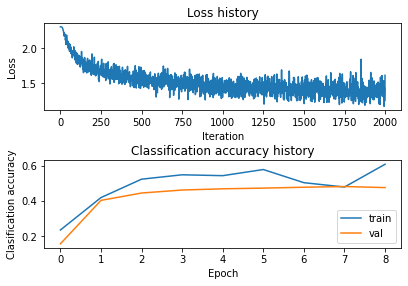

In [36]:
import matplotlib.pyplot as plt
# Plot the loss function and train / validation accuracies
def showStats(stats):
    fig, ax = plt.subplots(2, 1)

    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    fig.tight_layout(pad=1.5)

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')

    plt.legend()    
    plt.show()
    
showStats(stats)

In [37]:
def visualize_grid(xs, ubound=255.0, padding=1):
  """
  Reshape an image data of 4D tensor to a grid for the better understanding and visualization.

  Inputs:
  - xs: Data of shape (n, h, w, c)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (n, h, w, c) = xs.shape
  grid_size = int(ceil(sqrt(n)))
  grid_height = h * grid_size + padding * (grid_size - 1)
  grid_width = w * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, c))
  next_idx = 0
  y0, y1 = 0, h
  for y in range(grid_size):
    x0, x1 = 0, w
    for x in range(grid_size):
      if next_idx < n:
        img = xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx] #
        next_idx += 1
      x0 += w + padding
      x1 += w + padding
    y0 += h + padding
    y1 += h + padding
  # grid_max = np.max(grid) #
  # grid_min = np.min(grid) #
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min) #
  return grid

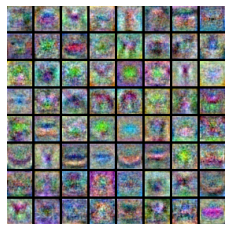

In [38]:
import math
from math import *

def show_net_weights(net):
  w1 = net_mlp.params['w1']

  ###########################################################################
  # PLACE YOUR CODE HERE                                                    #
  ###########################################################################
  # TODO: Implement the weight visualization     
  xs = w1.transpose(1,0).reshape(64, 32, 32, 3)
  plt.imshow(visualize_grid(xs, padding=3).astype('uint8'))
  # END OF YOUR CODE                           
  ###########################################################################

  plt.gca().axis('off')
  plt.show()

show_net_weights(net_mlp)